In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta
import requests
import matplotlib.pyplot as plt
import time # Imported for the ML class simulation

In [22]:

# --- SECTION 1: Machine Learning Model Training and Forecasting Class (ML_Train) ---

class ML_Train:
    """
    Class to encapsulate the ML pipeline steps:
    cleaning, feature engineering, model training, and recursive forecasting.
    Uses the larger PP_Historical_Weather.csv dataset.
    """
    
    TARGETS = [
        'T2M_MAX', 'T2M_MIN', 'T2M', 'RH2M', 
        'WS10M', 'WD10M', 'PRECTOTCORR'
    ]
    
    def __init__(self, data_file='PP_Historical_Weather.csv', city_name="Phnom Penh"):
        """Initializes the system, loading data from the specified CSV."""
        self.city_name = city_name
        self.raw_data = None
        self.df = None  
        self.models = {}
        self.training_summary = {}
        self.feature_cols = []
        self.last_row = None 
        
        # Simulate loading the training data
        try:
            
            self.raw_data = pd.read_csv(data_file, skiprows=16) 
        except FileNotFoundError:
            raise FileNotFoundError(f"ERROR: Training data file '{data_file}' not found.")

    def clean_data(self):
        """Initial data cleaning and feature generation (e.g., date index, wind components)."""
        df = self.raw_data.copy()
        
        # Create date column from YEAR, MO, DY
        df = df.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day'})
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        df = df.set_index('date').sort_index()
        df = df.drop(columns=['year', 'month', 'day'], errors='ignore')
        
        # Handle missing values (-999)
        df = df.replace(-999, np.nan)
        df = df.dropna(subset=self.TARGETS + ['PS'], how='any') 
        
        df['wind_speed_10m_kmh'] = df['WS10M'] * 3.6
        df['wind_dir_rad'] = np.deg2rad(df['WD10M'])
        # Corrected wind direction cosine calculation: WD10M is in degrees, needs to be converted to radians for numpy cos
        df['wind_dir_cos'] = np.cos(df['wind_dir_rad']) 
        df['wind_dir_sin'] = np.sin(df['wind_dir_rad'])
        
        self.raw_data = df
        return df

    def engineer_features(self, df):
        """Creates time-series (lag) and rolling statistical features."""
        df = df.copy()
        targets = self.TARGETS
        
        for col in targets:
            for lag in range(1, 8):
                df[f'{col}_lag{lag}'] = df[col].shift(lag)
        
        df['temp_max_roll_mean_3'] = df['T2M_MAX'].rolling(3).mean()
        df['temp_max_roll_mean_7'] = df['T2M_MAX'].rolling(7).mean()
        df['precip_roll_sum_7'] = df['PRECTOTCORR'].rolling(7).sum()
        df['humidity_roll_mean_7'] = df['RH2M'].rolling(7).mean()  
        df['pressure_roll_mean_7'] = df['PS'].rolling(7).mean()    
        
        df['month'] = df.index.month
        df['day'] = df.index.day
        df['dayofweek'] = df.index.dayofweek
        df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
        
        self.df = df.dropna()
        return self.df
    
    def update_for_realtime_forecast(self, current_df):
        """
        Adjusts the training data to ensure the forecast starts TODAY by appending
        a proxy row for YESTERDAY, if the last data point is too old.
        """
        if current_df is None or current_df.empty:
            return current_df
        
        yesterday = (datetime.now() - timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
        last_date_in_df = current_df.index[-1]
        
        if last_date_in_df.date() < yesterday.date():
            date_range_to_fill = pd.date_range(start=last_date_in_df + timedelta(days=1), end=yesterday, freq='D')
            
            if len(date_range_to_fill) > 0:
                print(f"  [ML System] Injecting {len(date_range_to_fill)} proxy features up to {yesterday.date()} for real-time start.")
                
                last_valid_row = current_df.iloc[-1].copy()
                proxy_rows = []
                
                for dt in date_range_to_fill:
                    new_row = last_valid_row.copy()
                    new_row.name = dt
                    
                    new_row['month'] = dt.month
                    new_row['day'] = dt.day
                    new_row['dayofweek'] = dt.weekday()
                    new_row['is_weekend'] = 1 if dt.weekday() >= 5 else 0
                    
                    proxy_rows.append(new_row)
                
                proxy_df = pd.DataFrame(proxy_rows, columns=current_df.columns)
                current_df = pd.concat([current_df, proxy_df])
                print(f"  [ML System] Data adjusted. Last feature date is now {current_df.index[-1].date()}.")
            
        self.df = current_df
        return self.df


    def train(self):
        """Trains the XGBoost model for each target variable."""
        targets = self.TARGETS
        
        if self.df is None:
            raise RuntimeError("Data must be cleaned and features engineered before training.")
            
        data = self.df
        
        exclude_cols = targets + ['WD10M', 'wind_dir_rad', 'WS10M', 'wind_speed_10m_kmh']
        self.feature_cols = [col for col in data.columns 
                             if col not in exclude_cols and ('_lag' in col or 'roll' in col or col in ['month', 'day', 'dayofweek', 'is_weekend', 'PS', 'wind_dir_sin', 'wind_dir_cos'])]
        
        self.feature_cols = list(set(self.feature_cols))

        if len(data) < 2:
             raise RuntimeError("Not enough historical data or proxy data to train the model and start the forecast.")
             
        # Use all data for training up to the last known day (which is 'yesterday' after update)
        X = data[self.feature_cols]
        self.last_row = data.iloc[-1]  
        data_train = data 
        
        # print(f"\nTraining XGBoost models on {len(X)} samples...")

        for target in targets:
            model = xgb.XGBRegressor(
                n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8,
                colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0,
                random_state=42, n_jobs=-1, tree_method='hist',  
            )
            model.fit(X, data_train[target])
            self.models[target] = model
            
            mae = mean_absolute_error(data_train[target], model.predict(X))
            unit = "°C" if 'T2M' in target else "mm" if 'PRECTOTCORR' in target else ""
            self.training_summary[target] = f"MAE: {mae:.3f}{unit}"

        # print("Training complete!")
        return self.models

    @staticmethod
    def degrees_to_direction(deg):
        """Converts degrees to cardinal direction."""
        deg = deg % 360 
        if deg < 22.5 or deg >= 337.5:   return "N"
        elif deg < 67.5:                 return "NE"
        elif deg < 112.5:                return "E"
        elif deg < 157.5:                return "SE"
        elif deg < 202.5:                return "S"
        elif deg < 247.5:                return "SW"
        elif deg < 292.5:                return "W"
        else:                            return "NW"
        
    def get_training_summary(self):
        """Provides accessible information about the trained models and their performance."""
        return self.training_summary

    def forecast_next_7_days(self, days=7):
        """Recursively forecasts the next N days."""
        if not self.models or self.last_row is None:
            raise RuntimeError("Model must be trained before forecasting.")

        current = self.last_row.copy()
        forecasts = []
        targets = self.TARGETS

        for i in range(1, days + 1):
            
            # 1. Prediction
            X = current[self.feature_cols].values.reshape(1, -1)
            pred = {}
            for target in targets:
                pred[target] = self.models[target].predict(X)[0]
            
            pred['PRECTOTCORR'] = max(0, pred['PRECTOTCORR'])
            forecast_date = current.name + timedelta(days=1) 
            
            # Weather description logic
            precip = pred['PRECTOTCORR']
            temp_mean = pred['T2M']
            if precip < 0.5:
                desc = "Sunny" if temp_mean >= 33 else "Mostly Sunny" if temp_mean >= 30 else "Partly Cloudy"
            elif precip < 3:
                desc = "Light Rain"
            elif precip < 10:
                desc = "Rainy"
            else:
                desc = "Heavy Rain"

            # Store results
            forecasts.append({
                "city": self.city_name,
                "date": forecast_date.strftime("%Y-%m-%d"),
                "max_temp": round(pred['T2M_MAX'], 1),
                "min_temp": round(pred['T2M_MIN'], 1),
                "mean_temp": round(pred['T2M'], 1),
                "rain_mm": round(pred['PRECTOTCORR'], 1),
                "wind_speed_kmh": round(pred['WS10M'] * 3.6, 1),
                "wind_dir_deg": round(pred['WD10M'], 0),
                "wind_direction": self.degrees_to_direction(pred['WD10M']),
                "description": desc
            })

            # 2. Feature Update for next iteration (shift lags, update new features)
            new_row = current.copy()
            new_row.name = forecast_date
            
            new_row['month'] = forecast_date.month
            new_row['day'] = forecast_date.day
            new_row['dayofweek'] = forecast_date.dayofweek
            new_row['is_weekend'] = 1 if forecast_date.weekday() >= 5 else 0

            for t in targets:
                for lag in range(7, 1, -1):
                    new_row[f'{t}_lag{lag}'] = current[f'{t}_lag{lag-1}']
                new_row[f'{t}_lag1'] = pred[t]
            
            # Update rolling features (approximation)
            new_row['temp_max_roll_mean_3'] = np.mean([
                pred['T2M_MAX'], current['T2M_MAX_lag1'], current['T2M_MAX_lag2']
            ])
            new_row['temp_max_roll_mean_7'] = np.mean([
                pred['T2M_MAX']] + [current[f'T2M_MAX_lag{i}'] for i in range(1, 7)]
            )
            new_row['precip_roll_sum_7'] = sum([
                pred['PRECTOTCORR']] + [current[f'PRECTOTCORR_lag{i}'] for i in range(1, 7)]
            )
            new_row['humidity_roll_mean_7'] = np.mean([
                pred['RH2M']] + [current[f'RH2M_lag{i}'] for i in range(1, 7)]
            )
            new_row['pressure_roll_mean_7'] = current['PS'] 

            rad = np.deg2rad(pred['WD10M'])
            new_row['wind_dir_sin'] = np.sin(rad)
            new_row['wind_dir_cos'] = np.cos(rad)

            for t in targets:
                 new_row[t] = pred[t] 

            current = new_row

        return forecasts

# --- ML Execution Wrapper ---

def ml_forecast_data(city_name="Phnom Penh"):
    """
    Function to run the ML forecast pipeline and return structured 7-day forecast data.
    """
    if city_name != "Phnom Penh":
        print(f"ML Model is only trained for {city_name}.")
        return []
        
    try:
        # Simulate processing time for a complex ML forecast
        time.sleep(1.5)
        
        system = ML_Train(city_name=city_name)
        
        df_cleaned = system.clean_data()
        df_engineered = system.engineer_features(df_cleaned)
        
        system.update_for_realtime_forecast(df_engineered) 
        
        system.train()
        forecast_results = system.forecast_next_7_days(days=7)
        
        return forecast_results

    except FileNotFoundError as e:
        print(e)
        return []
    except RuntimeError as e:
        print(f"Runtime Error in ML Pipeline: {e}")
        return []
    except Exception as e:
        print(f"An unexpected error occurred during ML pipeline execution: {e}")
        return []




In [ ]:

# --- SECTION 2: Reusable Visualization Class (WEATHER_VISUALIZATION) ---

class WEATHER_VISUALIZATION:

    def plot_8day_combined(self, data_list, city_name, source_name="Data Source", chart_style='B'):
        """
        Plots 8 days of data (Current + 7-Day) showing Mean Temp and Rainfall.
        chart_style: 'B' for Bar Chart (default), 'L' for Line Chart.
        """
        if not data_list:
            print(f"Cannot visualize: Data list for {city_name} is empty or None.")
            return

        df = pd.DataFrame(data_list)
        df['date'] = df['date'].str.replace(' \(Current\)', '\n(Today)', regex=True)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        fig.suptitle(f'8-Day Weather Forecast for {city_name.upper()} ({source_name})', fontsize=16, weight='bold')

        # --- Subplot 1: Mean Temperature (Dynamic Style) ---
        
        color_temp = '#1f77b4' # blue
        ax1.set_ylabel('Mean Temp (°C)', color=color_temp)

        if chart_style == 'B':
            # Bar Chart Style 
            main_plot_elements = ax1.bar(df['date'], df['mean_temp'], color=color_temp, alpha=0.7, label='Mean Temp (Bar)')
            
        else: # Line Chart Style
            ax1.plot(df['date'], df['mean_temp'], color=color_temp, marker='o', linestyle='-', label='Mean Temp (Line)')
            
        ax1.tick_params(axis='y', labelcolor=color_temp)
        
        ax1.set_title('Temperature and Daily Conditions', fontsize=12)
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

        #Annotations (placed consistently using index for x-position)
        for i, row in df.iterrows():
            description = row['description']
            #rain = row['rain_mm']
            
            y_pos = row['mean_temp'] 
            x_pos = i 
            
            ax1.text(x_pos, y_pos + 0.3, 
                     f"{description}", ha='center', fontsize=9, rotation=0, weight='bold')


        # --- Subplot 2: Rainfall (Always Line Chart) ---
        color_rain = 'green'
        ax2.set_ylabel('Rainfall (mm)', color=color_rain)  
        ax2.plot(df['date'], df['rain_mm'], color=color_rain, marker='o', linestyle='-', label='Rainfall (mm)')
        ax2.tick_params(axis='y', labelcolor=color_rain)
        ax2.set_ylim(bottom=0, top=df['rain_mm'].max() * 1.5 + 5) 
        ax2.set_xlabel('Date') 
        ax2.set_title('Total Daily Precipitation', fontsize=12)
        ax2.grid(axis='y', linestyle='--', alpha=0.5)
        
        plt.xticks(rotation=0, ha='center')
        fig.tight_layout(rect=[0, 0.03, 1, 0.97])
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1, labels1, loc='upper left')
        ax2.legend(lines2, labels2, loc='upper left')

        plt.show()     


    def compare_forecasts(self, api_data, ml_data, city_name, chart_style='B'):
        
        """
        Plots a side-by-side comparison of API Max Temp vs ML Model Max Temp.
        chart_style: 'B' for Bar Chart (default), 'L' for Line Chart.
        """
    
        if not api_data or not ml_data:
            print("Cannot compare: Missing data for one or both sources.")
            return

        df_api = pd.DataFrame(api_data).rename(columns={'max_temp': 'API_Max'})
        df_ml = pd.DataFrame(ml_data).rename(columns={'max_temp': 'ML_Max'})
        
        df_api['date'] = df_api['date'].str.replace(' \(Current\)', '\n(Today)', regex=True)
        df_ml['date'] = df_ml['date'].str.replace(' \(Current\)', '\n(Today)', regex=True)
        
        df_comp = pd.merge(df_api[['date', 'API_Max']], df_ml[['date', 'ML_Max']], on='date', how='inner')
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        if chart_style == 'B':
            # Bar Chart Style
            x = np.arange(len(df_comp['date']))
            width = 0.35
            rects1 = ax.bar(x - width/2, df_comp['API_Max'], width, label='API Max Temp', color='#e74c3c')
            rects2 = ax.bar(x + width/2, df_comp['ML_Max'], width, label='ML Max Temp', color='#2ecc71')
            ax.set_xticks(x)
            ax.set_xticklabels(df_comp['date'], rotation=0)
            
            # Function to attach a text label above each bar
            def autolabel(rects):
                for rect in rects:
                    height = rect.get_height()
                    ax.annotate(f'{height:.1f}°C',
                                xy=(rect.get_x() + rect.get_width() / 2, height),
                                xytext=(0, 3), 
                                textcoords="offset points",
                                ha='center', va='bottom', fontsize=9)

            autolabel(rects1)
            autolabel(rects2)

        else: 
            # Line Chart Style
            ax.plot(df_comp['date'], df_comp['API_Max'], marker='o', linestyle='-', label='API Max Temp', color='#e74c3c')
            ax.plot(df_comp['date'], df_comp['ML_Max'], marker='o', linestyle='-', label='ML Max Temp', color='#2ecc71')
            
          

        ax.set_title(f'Max Temperature Comparison for {city_name.upper()} (API vs. ML Model)', fontsize=16)
        ax.set_ylabel('Max Temperature (°C)')
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.5)

        fig.tight_layout()
        plt.show()

In [ ]:

# --- SECTION 3: API Fetching and Main Application Logic (API_FETCHING) ---

class API_FETCHING:
    
    API_KEY = "dca885a7f61210902aaea785372a6d41" 
    BASE_WEATHER_URL = "https://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"
    BASE_ONECALL_URL = "https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&exclude=minutely,hourly,alerts&units=metric&appid={API_KEY}"

    def _get_api_response(self, url, error_msg):
        """Internal helper to handle API requests and errors."""
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error during API call: {error_msg}. Details: {e}")
            return None

    def get_current_weather(self, city):
        """Fetches current weather and structures it for merging."""
        url = self.BASE_WEATHER_URL.format(city=city, API_KEY=self.API_KEY)
        data = self._get_api_response(url, f"Current weather for {city}")
        if not data: return None
        
        # Structure current day data to match the common 8-day format
        return {
            "city": data.get('name', city),
            "date": datetime.fromtimestamp(data['dt']).strftime("%Y-%m-%d (Current)"),
            "max_temp": round(data["main"]["temp_max"], 1),
            "min_temp": round(data["main"]["temp_min"], 1),
            "mean_temp": round(data["main"]["temp"], 1), 
            "rain_mm": data.get("rain", {}).get("1h", data.get("rain", {}).get("3h", 0.0)),
            "description": data["weather"][0]["description"].capitalize()
        }

    def get_forecast_only(self, lat, lon):
        """Fetches 7-day forecast using coordinates."""
        url2 = self.BASE_ONECALL_URL.format(lat=lat, lon=lon, API_KEY=self.API_KEY)
        data2 = self._get_api_response(url2, "7-day forecast (One Call API 3.0)")
        if not data2 or 'daily' not in data2: return None
        
        forecast_data_list = []
        for day in data2['daily'][:7]: # Limit to next 7 days
            dt = datetime.fromtimestamp(day['dt'])
            
            mean_temp = round((day['temp']['day'] + day['temp']['eve'] + day['temp']['morn'] + day['temp']['night']) / 4, 1)
            
            forecast_data_list.append({
                "city": data2.get('name', 'N/A'),
                "date": dt.strftime("%Y-%m-%d"),
                "max_temp": round(day['temp']['max'], 1),
                "min_temp": round(day['temp']['min'], 1),
                "mean_temp": mean_temp,
                "rain_mm": day.get('rain', 0.0), 
                "description": day['weather'][0]['description'].capitalize()
            })
        return forecast_data_list

    def get_full_8day_data(self, city_name):
        """Merges current data and 7-day forecast (API source) into a single 8-day list."""
        current_data_dict = self.get_current_weather(city_name)
        if not current_data_dict: return None
        
        coord_url = self.BASE_WEATHER_URL.format(city=city_name, API_KEY=self.API_KEY)
        coord_data = self._get_api_response(coord_url, "Coordinates for forecast")
        if not coord_data or 'coord' not in coord_data: return None
        
        lat = coord_data['coord']['lat']
        lon = coord_data['coord']['lon']
        
        forecast_list = self.get_forecast_only(lat, lon)
        if not forecast_list: return None
        
        full_data = [current_data_dict] + forecast_list
        return full_data

    def get_ml_full_8day_data(self, city_name):
        """
        Combines today's actual weather (from API) with the ML model's
        7-day forecast (starting tomorrow) to create a consistent 8-day list.
        """
        if city_name != "Phnom Penh":
            return None

        print(f"\n[ML] Starting prediction process for {city_name}...")
        
        current_data_dict = self.get_current_weather(city_name)
        if not current_data_dict: 
            print("ERROR: Could not fetch today's current weather from API for ML comparison.")
            return None
        
        # Call the ml_forecast_data wrapper defined outside this class
        ml_7day_forecast = ml_forecast_data(city_name)
        
        if not ml_7day_forecast:
            print("ERROR: ML model failed to generate a 7-day forecast.")
            return None
            
        full_data = [current_data_dict] + ml_7day_forecast
        
        print(f"[ML] Successfully merged 7-day forecast with today's API data.")
        return full_data

    def cityoption(self):
        """Handles the user I/O menu for fetching, visualization, and comparison."""
        print("\n--- WEATHER TOOL MENU ---")
        province =  ["Phnom Penh", "Banteay Meanchey", "Battambang", "Kampong Cham", "Kampong Chhnang", 
                    "Kampong Speu", "Kampong Thom", "Kampot", "Kandal", "Kep", "Koh Kong", "Kratié", 
                    "Mondulkiri", "Oddar Meanchey", "Pailin", "Preah Vihear", "Preah Sihanouk", 
                    "Prey Veng", "Pursat", "Ratanakiri", "Siem Reap", "Stung Treng", "Svay Rieng", 
                    "Takeo", "Tbong Khmum"]
                    
        for idx, ProvinceName in enumerate(province, start=1):
            print(f"{idx}. {ProvinceName}")
            
        while True:
            try:
                city_name_input = input("Please input the number of the province/city: ")
                city_name_index = int(city_name_input)
                
                if not (1 <= city_name_index <= len(province)):
                    print(f"Invalid input. Please enter a number between 1 and {len(province)}.")
                    continue 

                city = province[city_name_index - 1]
                

                while True:
                    print("\nChoose Visualization Style for Temperature plots (Rainfall is always Line):")
                    print("B: Bar Chart (Default)")
                    print("L: Line Chart")
                    chart_style_input = input("Enter style (B/L): ").strip().upper()
                    
                    if chart_style_input in ["B", "L"]:
                        chart_style = chart_style_input
                        break
                    else:
                        print("Invalid style option. Please enter B or L.")
                

                print("\nChoose Action:")
                print("F: API Forecast Visualization (8-Day Combined)")
                print("M: ML Model Forecast Visualization (8-Day Combined)")
                print("C: Compare API vs. ML Model Max Temperatures")
                
                option = input("Enter option (F/M/C): ")
                visualizer = WEATHER_VISUALIZATION() 
                
                match(option.upper()):
                    case "F":
                        print(f"Fetching API data for {city}...")
                        full_8day_data = self.get_full_8day_data(city)
                        if full_8day_data:
                            # Pass the chosen chart_style
                            visualizer.plot_8day_combined(full_8day_data, city, source_name="OpenWeatherMap API", chart_style=chart_style)
                        break
                        
                    case "M":
                        if city == "Phnom Penh":
                            ml_data = self.get_ml_full_8day_data(city)
                            if ml_data:
                                # Pass the chosen chart_style
                                visualizer.plot_8day_combined(ml_data, city, source_name="ML Model Prediction", chart_style=chart_style)
                            break
                        else:
                            print("The ML model can only Forecast data in Phnom Penh")
                            continue 
                            
                    case "C":
                        
                        if city == "Phnom Penh":
                            print("\n[Comparison] Fetching API data...")
                            api_data = self.get_full_8day_data(city)
                            
                            print("[Comparison] Generating ML Model data...")
                            ml_data = self.get_ml_full_8day_data(city) 
                            
                            if api_data and ml_data:
                                # Pass the chosen chart_style
                                visualizer.compare_forecasts(api_data, ml_data, city, chart_style=chart_style)
                            else:
                                print("Comparison failed: Could not retrieve data from one or both sources.")
                            break
                        else:
                            print("The ML model can only Forecast data in Phnom Penh")
                            continue
                            
                    case _:
                        print("Invalid Option! Please enter F, M, or C.")

            except ValueError:
                print("!!Invalid input. Please enter a valid integer!!.")


This tool compares real-time OpenWeatherMap API data against a custom, locally-trained XGBoost Machine Learning model.

--- WEATHER TOOL MENU ---
1. Phnom Penh
2. Banteay Meanchey
3. Battambang
4. Kampong Cham
5. Kampong Chhnang
6. Kampong Speu
7. Kampong Thom
8. Kampot
9. Kandal
10. Kep
11. Koh Kong
12. Kratié
13. Mondulkiri
14. Oddar Meanchey
15. Pailin
16. Preah Vihear
17. Preah Sihanouk
18. Prey Veng
19. Pursat
20. Ratanakiri
21. Siem Reap
22. Stung Treng
23. Svay Rieng
24. Takeo
25. Tbong Khmum

Choose Visualization Style for Temperature plots (Rainfall is always Line):
B: Bar Chart (Default)
L: Line Chart

Choose Action:
F: API Forecast Visualization (8-Day Combined)
M: ML Model Forecast Visualization (8-Day Combined)
C: Compare API vs. ML Model Max Temperatures

[Comparison] Fetching API data...
[Comparison] Generating ML Model data...

[ML] Starting prediction process for Phnom Penh...
  [ML System] Injecting 13 proxy features up to 2025-11-30 for real-time start.
  [ML System]

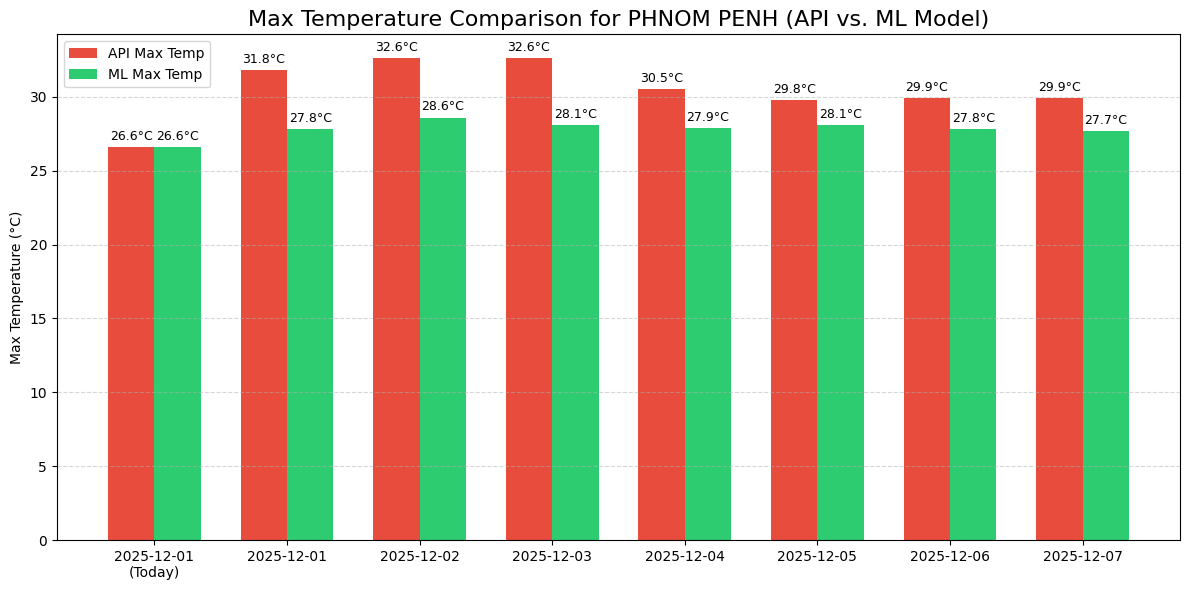

In [25]:
# --- SECTION 4: Execution ---

if __name__ == '__main__':
    print("This tool compares real-time OpenWeatherMap API data against a custom, locally-trained XGBoost Machine Learning model.")
    api_weather = API_FETCHING()
    api_weather.cityoption()